#### Gland Segmentation (Colorectal Cancer)

Overview
Most organ systems have glands, which are essential to histology because they are the primary mechanism for the secretion of proteins and carbohydrates. Malignant tumours called adenocarcinomas originate from glandular epithelial cells and are among the most common forms of cancer. Pathologists often rely on glandular morphology to evaluate the severity of malignancy in adenocarcinomas affecting organs such as the colon, breast, prostate, and lungs.

Accurate gland segmentation is essential for generating reliable morphological insights. However, this task is inherently complex due to the significant variations in glandular structures across different histological grades. The majority of current research focuses on gland segmentation in benign or healthy tissues, although intermediate or high-grade cancer instances have received less attention. Furthermore, the versatility of many segmentation techniques is limited because they are customized for specific datasets. 

This challenge invites participants to apply gland segmentation algorithms to Hematoxylin and Eosin (H&E)-stained histological slides encompassing a range of histological grades. The dataset includes expert-annotated ground truth labels. Participants are tasked with designing and refining their segmentation models using the training dataset and evaluating their performance on the test dataset.


#### Setup

In [ ]:
! pip install git+https://github.com/fastai/fastai.git
! pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

#### Exploratory Data Analysis

In [ ]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation

import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc,roc_curve
from sklearn.metrics import classification_report

In [ ]:
path= Path('Warwick_Dataset/Data/')
path.ls()

[PosixPath('Warwick_Dataset/Data/test'),
 PosixPath('Warwick_Dataset/Data/gland_unet_224-90d.pkl'),
 PosixPath('Warwick_Dataset/Data/train'),
 PosixPath('Warwick_Dataset/Data/models')]

In [ ]:
df=pd.read_csv(path.parent/'Grade.csv')
df.head()

name  patient ID  grade (GlaS)  grade (Sirinukunwattana et al. 2015)
0   testA_1           4        benign                           adenomatous
1  testA_10          10        benign                               healthy
2  testA_11           9        benign                               healthy
3  testA_12          11     malignant                 poorly differentiated
4  testA_13           7     malignant             moderately differentiated

In [ ]:
classes=list(set(df.iloc[:,3]))
classes =['Void',' poorly differentiated',
 ' moderately-to-poorly differentated',
 ' moderately differentiated',
 ' healthy',
 ' adenomatous']

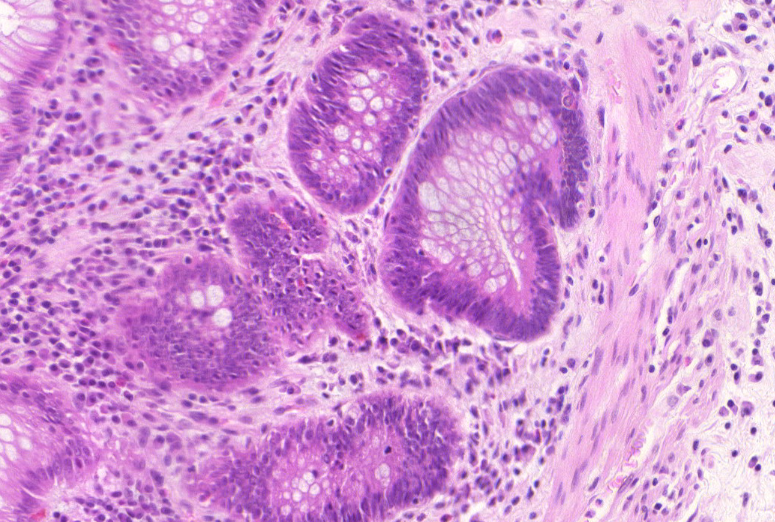

In [ ]:
path_imgs= path/'train'
img_f=path_imgs.ls()[0]
open_image(img_f)

In [ ]:
path_lbs=(path.parent/'Annotations')

In [ ]:
def get_labels(x):
    if str(x).split('/')[-2] =='train': x= path_lbs/f'Train_Ann/{x.stem}_anno{x.suffix}'
    else: x = path_lbs/f'Test_A/{x.stem}_anno{x.suffix}'
    return x

Warwick_Dataset/Data/train/train_38.bmp


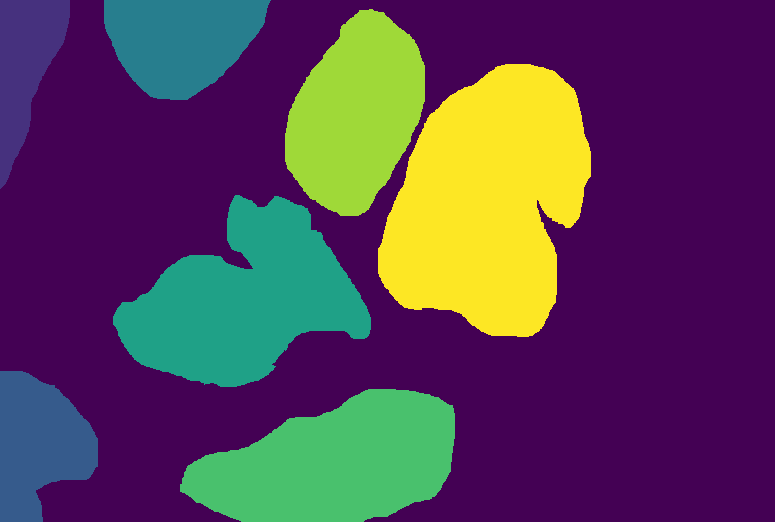

In [ ]:
print(img_f)
open_mask(get_labels(img_f))

In [ ]:
def open_mk(fn:PathOrStr, div:bool=False, convert_mode:str='L', cls:type=ImageSegment,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    x[x>0]=1
    if div: x.div_(255)
    return cls(x)

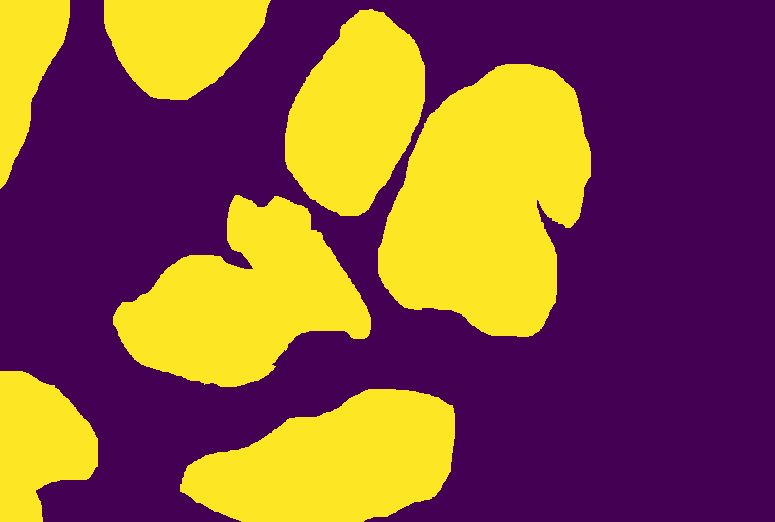

In [ ]:
open_mk(get_labels(img_f))

In [ ]:
class GlandSegmentationLabelList(SegmentationLabelList):
    def open(self,fn): return open_mk(fn)
    
class GlandSegmentationItemList(ImageList):
    _label_cls= GlandSegmentationLabelList

In [ ]:
GlandSegmentationItemList.from_folder(path)

GlandSegmentationItemList (165 items)
Image (3, 522, 775),Image (3, 522, 775),Image (3, 522, 775),Image (3, 442, 581),Image (3, 522, 775)
Path: Warwick_Dataset/Data

In [ ]:
src=(GlandSegmentationItemList.from_folder(path)
         .split_by_rand_pct()
         .label_from_func(get_labels,classes=['bening','malignat']))

In [ ]:
def get_data(bs, size, **kwargs):
    data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
            .databunch(bs=bs, num_workers=0, **kwargs)
            .normalize(imagenet_stats))
    return data

In [ ]:
data = get_data(8, 224)

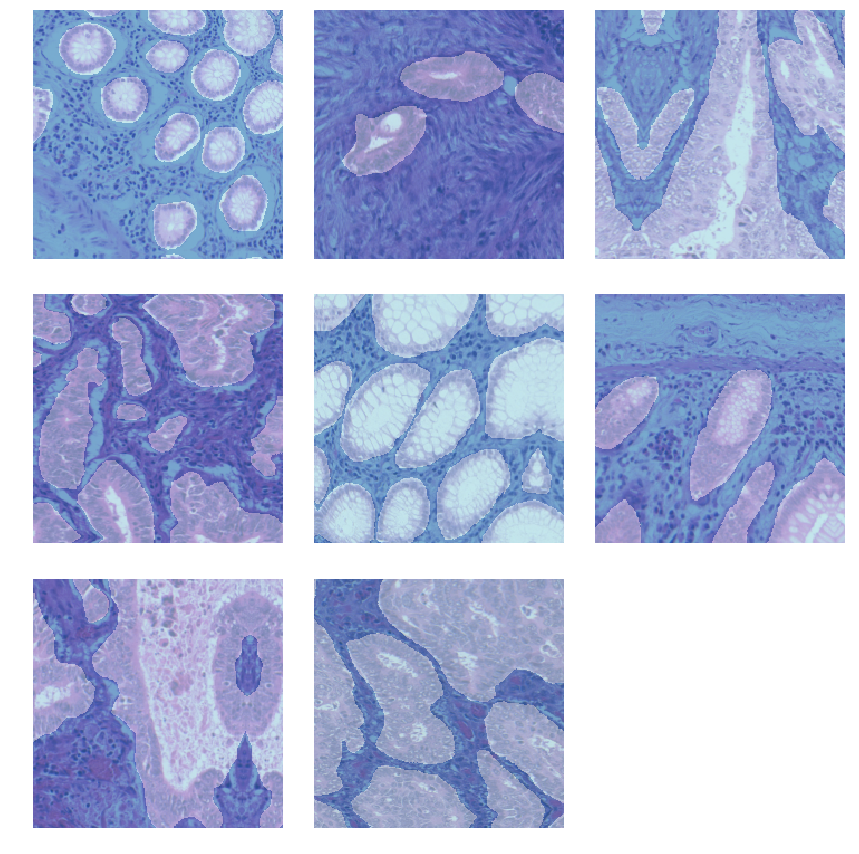

In [ ]:
data.show_batch(rows=3, alpha=0.6)

## Training

In [ ]:
def accuracy_gland(input, target):
    target=target.squeeze(1)
    mask =target>0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='unet_224'),
        ShowGraph]

In [ ]:
learner= unet_learner(data, models.resnet50, metrics=[accuracy_gland, dice], callback_fns=cbfs).load('unet_224-90d')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


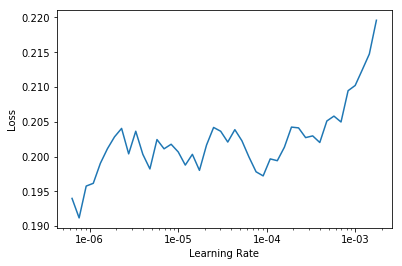

In [ ]:
learner.lr_find()
learner.recorder.plot()

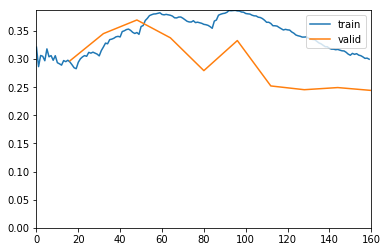

Epoch 1: reducing lr to 0.000152
Epoch 2: reducing lr to 0.0002
Epoch 3: reducing lr to 0.00019009692640269474
Epoch 5: reducing lr to 0.00012225240438725783
Epoch 8: reducing lr to 9.903873597305257e-06


In [ ]:
lr= 1e-3
learner.fit_one_cycle(15, lr,  wd=1e-2)

In [ ]:
learner.save('unet_224-89acc')

In [ ]:
learner.unfreeze()
learner.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (132 items)
x: GlandSegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: GlandSegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: Warwick_Dataset/Data;

Valid: LabelList (33 items)
x: GlandSegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: GlandSegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: Warwick_Dataset/Data;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): R

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


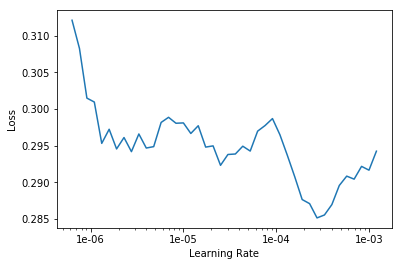

In [ ]:
learner.lr_find()
learner.recorder.plot()

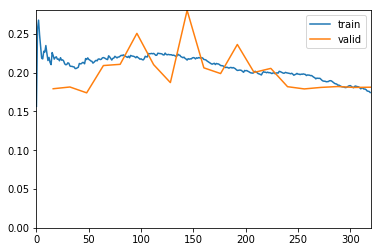

Epoch 1: reducing lr to 2.800000000000001e-05
Epoch 3: reducing lr to 7.6e-05
Epoch 4: reducing lr to 9.356921938165309e-05
Epoch 5: reducing lr to 0.00010000000000000003
Epoch 6: reducing lr to 9.874640062350878e-05
Epoch 7: reducing lr to 9.504846320134738e-05
Epoch 8: reducing lr to 8.909161775710502e-05
Epoch 9: reducing lr to 8.117456539497633e-05
Epoch 10: reducing lr to 7.16943001791301e-05
Epoch 11: reducing lr to 6.112620219362893e-05
Epoch 12: reducing lr to 5.000020000000001e-05
Epoch 13: reducing lr to 3.887419780637108e-05
Epoch 14: reducing lr to 2.8306099820869926e-05
Epoch 15: reducing lr to 1.8825834605023703e-05
Epoch 16: reducing lr to 1.0908782242895006e-05
Epoch 17: reducing lr to 4.95193679865263e-06
Epoch 18: reducing lr to 1.2539993764912559e-06
Epoch 19: reducing lr to 4.000000000000001e-10


In [ ]:
lr=1e-3
learner.fit_one_cycle(20, slice(1e-5,lr/2), wd=1e-2)

In [ ]:
learner.save('unet_224_16')

In [ ]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) 
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)

### 512 Out of Memory

In [ ]:
data= get_data(4, 512)

In [ ]:
cbfs = [ReduceLROnPlateauCallback,
        partial(SaveModelCallback,every='epoch',name='unet_512'),
        ShowGraph]

In [ ]:
learner= unet_learner(data, models.resnet50, metrics=[accuracy_gland, dice], callback_fns=cbfs).load('unet_224-90d')

In [ ]:
learner.lr_find()
learner.recorder.plot()

## Evaluation

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)

In [ ]:
learner.data.classes


['bening', 'malignat']

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

label     score
1  malignat  0.932383
0    bening  0.901241

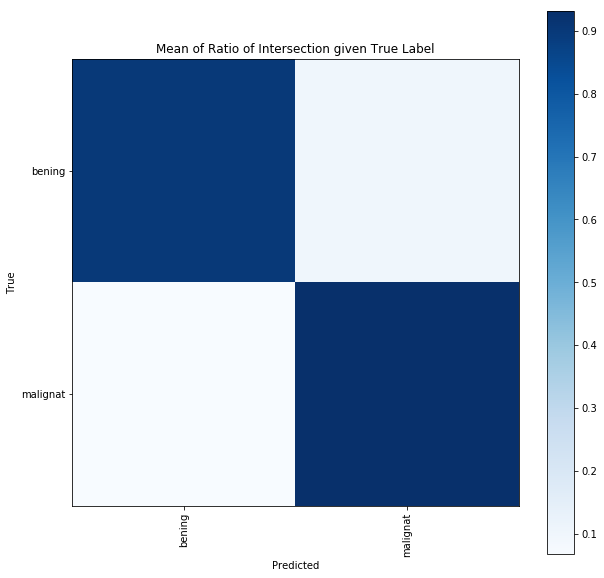

In [ ]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

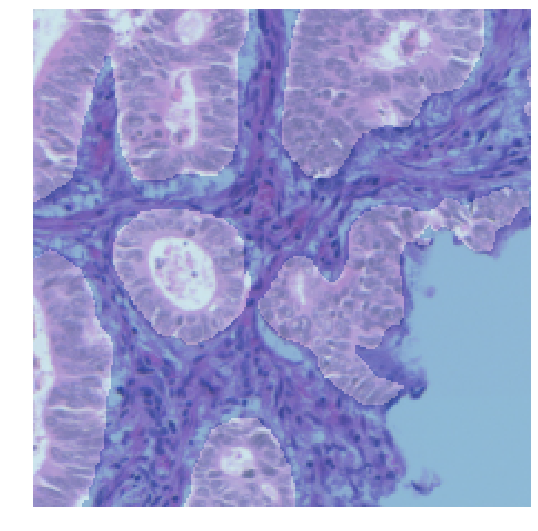

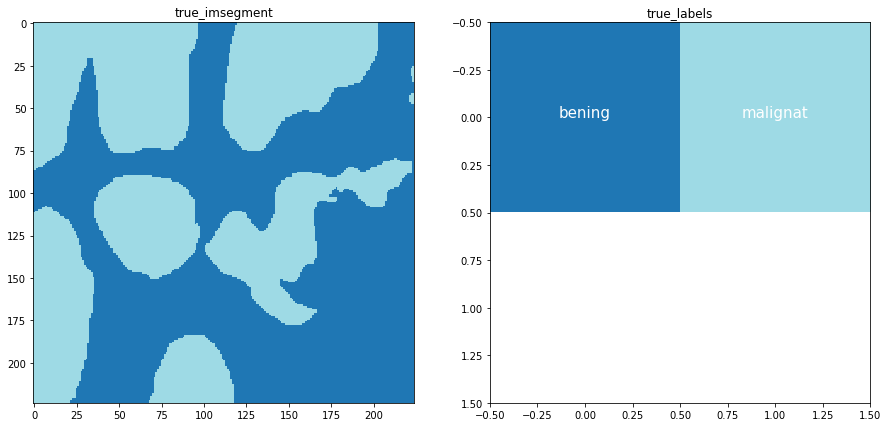

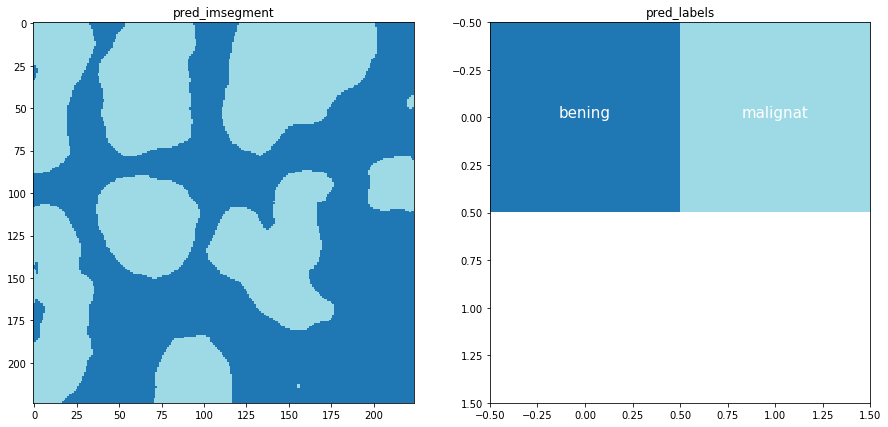

In [ ]:
interp.show_xyz(0, sz=15)

## Inference

In [ ]:
learner.load('unet_224_16')

In [ ]:
learner.export(file='models/gland_unet_224-93d.pkl')

In [ ]:
model_file= 'gland_unet_224-93d.pkl'
stage_model='unet_224_16.pth'
path_local_models=(path/'models')
model_local_file=str(path_local_models/stage_model)
upload_files_to_gcp(model_local_file, path_bc_models)

Copying file://Warwick_Dataset/Data/models/unet_224_16.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.



In [ ]:
class Inference():
  def __init__(self, path, file_name): 
    """ Inference 
    :path = path to the .pkl file
    :file_name
    return: class prediction
    """
    self.learner=load_learner(path, file_name)
    self.learner.model.float()
  
  def __call__(self, img):
    img=open_image(img) if not isinstance(img,fastai.vision.image.Image ) else img
    masks= self.learner.predict(img)
    img  = self.learner.data.one_item(img)[0]
    if getattr(learner.data,'norm',False): img = learner.data.denorm(img)
    img=torch.squeeze(img, dim=0)
    image= Image(img)
    return image, masks[0]

In [ ]:
predict_img_seg= Inference(path_local_models, model_file)

torch.Size([3, 224, 224])
torch.Size([3, 522, 775])


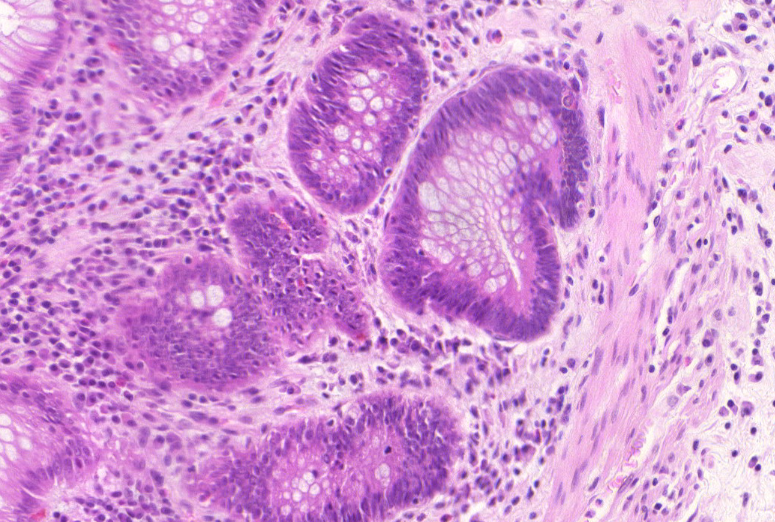

In [ ]:
im= open_image(img_f)
print(im.shape)
im

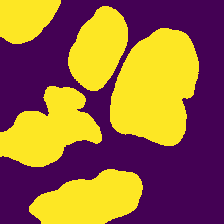

In [ ]:
image, mask_pred=predict_img_seg(im)
mask_pred

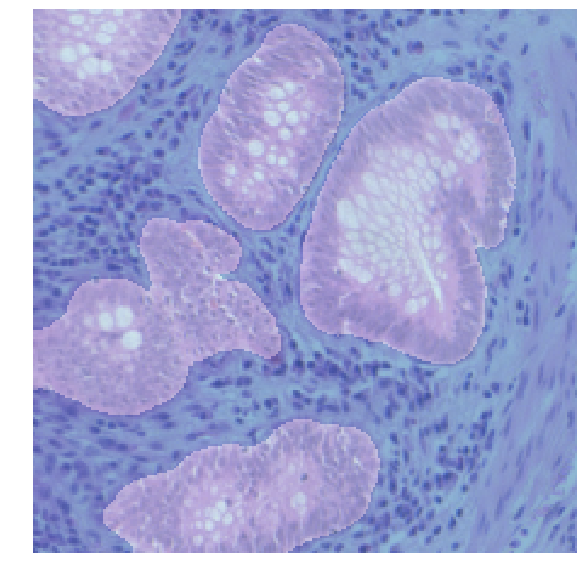

In [ ]:
image.show(y=mask_pred, figsize=(10,10), alpha=0.5)